In [74]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torch.nn as nn

import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [76]:
device

device(type='cuda')

In [77]:
IMAGE_SIZE = 64
STATS = (0.5,0.5,0.5), (0.5,0.5,0.5)

LATENT_SIZE = 100
BATCH = 128
EPOCHS = 100
LR = 0.0002

DIR = '../input/cats-faces-64x64-for-generative-models/'

In [78]:
transform = transforms.Compose(
    [
     transforms.Resize(IMAGE_SIZE),
     transforms.CenterCrop(IMAGE_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(*STATS)
    ]
)

trainDataset = ImageFolder(
    DIR,
    transform=transform
)

trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH,
    shuffle=True,
    num_workers=3,
    pin_memory=True
)

In [79]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #input size: (3 x 64 x 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            #output size: (1 x 1 x 1)

            nn.Flatten(),
            nn.Sigmoid()

        )

    def forward(self, x):
        output= self.model(x)
        return output

In [80]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            #input size: (LATENT * 1 * 1)
            nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            #output size: (3 x 64 x 64)
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [81]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

In [82]:
LOSS = nn.BCELoss()
FIXED_LATENT = torch.randn(64, LATENT_SIZE, 1, 1, device=device)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))

In [83]:
# torch.cuda.empty_cache()
lossD = []
lossG = []

for epoch in range(EPOCHS):
    for REAL, _ in tqdm(trainDataLoader):
        if int(REAL.shape[0]) == 128:
            #data for discriminator
            LATENT_SPACE = torch.randn((BATCH, LATENT_SIZE, 1, 1)).to(device=device)

            REAL_IMAGES = REAL.to(device=device)
            REAL_LABELS = torch.ones((BATCH, 1)).to(device=device)

            GENERATED_IMAGES = generator(LATENT_SPACE)
            GENERATED_LABELS = torch.zeros((BATCH, 1)).to(device=device)

            #training discriminator
            discriminator.zero_grad()
            discriminator_output_real = discriminator(REAL_IMAGES)
            discriminator_output_generated = discriminator(GENERATED_IMAGES)
            
#             discriminator_loss = F.binary_cross_entropy(discriminator_output, ALL_LABELS)
            discriminator_loss_real = LOSS(discriminator_output_real, REAL_LABELS)
            discriminator_loss_generated = LOSS(discriminator_output_generated, GENERATED_LABELS)
    
            discriminator_loss = discriminator_loss_real + discriminator_loss_generated
            discriminator_loss.backward()
            discriminator_optimizer.step()

            #data for generator
            LATENT_SPACE = torch.randn((BATCH, LATENT_SIZE, 1, 1)).to(device=device)

            #training generator
            generator.zero_grad()
            generator_output = generator(LATENT_SPACE)
            generator_discriminator_output = discriminator(generator_output)
#             generator_loss = F.binary_cross_entropy(generator_discriminator_output, REAL_LABELS)
            generator_loss = LOSS(generator_discriminator_output, REAL_LABELS)
            generator_loss.backward()
            generator_optimizer.step()

    print(f'Epoch: {epoch}.')
    print(f'Loss G: {generator_loss}.')
    print(f'Loss D: {discriminator_loss}.')

    lossG.append(generator_loss)
    lossD.append(discriminator_loss)

    DIR = 'examples'
    os.makedirs(DIR, exist_ok=True)
    image = generator(FIXED_LATENT)
    image = image * STATS[1][0] + STATS[0][0]
    image_name = f'IMAGE_EPOCH_{epoch}.png'
    save_image(image, f'{DIR}/{image_name}', nrow=8)
    print(f'{image_name} saved.')


Epoch: 0.
Loss G: 2.5973329544067383.
Loss D: 0.40985727310180664.
IMAGE_EPOCH_0.png saved.



Epoch: 1.
Loss G: 2.3187618255615234.
Loss D: 0.7621304988861084.
IMAGE_EPOCH_1.png saved.



Epoch: 2.
Loss G: 3.675642728805542.
Loss D: 1.0906264781951904.
IMAGE_EPOCH_2.png saved.



Epoch: 3.
Loss G: 5.4481306076049805.
Loss D: 0.715128481388092.
IMAGE_EPOCH_3.png saved.



Epoch: 4.
Loss G: 3.225999116897583.
Loss D: 0.44939330220222473.
IMAGE_EPOCH_4.png saved.



Epoch: 5.
Loss G: 3.330042600631714.
Loss D: 0.3926311433315277.
IMAGE_EPOCH_5.png saved.



Epoch: 6.
Loss G: 2.012845754623413.
Loss D: 0.45454517006874084.
IMAGE_EPOCH_6.png saved.



Epoch: 7.
Loss G: 3.0304322242736816.
Loss D: 0.2873353958129883.
IMAGE_EPOCH_7.png saved.



Epoch: 8.
Loss G: 2.662503957748413.
Loss D: 0.11740071326494217.
IMAGE_EPOCH_8.png saved.



Epoch: 9.
Loss G: 5.850516319274902.
Loss D: 0.6232409477233887.
IMAGE_EPOCH_9.png saved.



Epoch: 10.
Loss G: 3.7820968627929688.
Loss D: 0.2045086771249771.
IMAGE_EPOCH_10.png saved.



Epoch: 11.
Loss G: 6.409204483032227.
Loss D: 0.5235397815704346.
IMAGE_EPOCH_11.png saved.



Epoch: 12.
Loss G: 6.362323760986328.
Loss D: 0.038444455713033676.
IMAGE_EPOCH_12.png saved.



Epoch: 13.
Loss G: 4.22653341293335.
Loss D: 2.3288304805755615.
IMAGE_EPOCH_13.png saved.



Epoch: 14.
Loss G: 11.460884094238281.
Loss D: 0.939608633518219.
IMAGE_EPOCH_14.png saved.



Epoch: 15.
Loss G: 4.887700080871582.
Loss D: 0.3486325442790985.
IMAGE_EPOCH_15.png saved.



Epoch: 16.
Loss G: 6.688388824462891.
Loss D: 0.07256684452295303.
IMAGE_EPOCH_16.png saved.



Epoch: 17.
Loss G: 4.9229278564453125.
Loss D: 0.05061528831720352.
IMAGE_EPOCH_17.png saved.



Epoch: 18.
Loss G: 6.335855007171631.
Loss D: 0.06705553829669952.
IMAGE_EPOCH_18.png saved.



Epoch: 19.
Loss G: 6.335789680480957.
Loss D: 0.02921946346759796.
IMAGE_EPOCH_19.png saved.



Epoch: 20.
Loss G: 4.930309295654297.
Loss D: 0.08180955052375793.
IMAGE_EPOCH_20.png saved.



Epoch: 21.
Loss G: 5.709035873413086.
Loss D: 0.31254926323890686.
IMAGE_EPOCH_21.png saved.



Epoch: 22.
Loss G: 5.383303165435791.
Loss D: 0.03577723726630211.
IMAGE_EPOCH_22.png saved.



Epoch: 23.
Loss G: 4.574154853820801.
Loss D: 0.057306528091430664.
IMAGE_EPOCH_23.png saved.



Epoch: 24.
Loss G: 6.651862144470215.
Loss D: 0.03148651495575905.
IMAGE_EPOCH_24.png saved.



Epoch: 25.
Loss G: 5.45814847946167.
Loss D: 0.11704270541667938.
IMAGE_EPOCH_25.png saved.



Epoch: 26.
Loss G: 8.588841438293457.
Loss D: 0.35578498244285583.
IMAGE_EPOCH_26.png saved.



Epoch: 27.
Loss G: 5.2993927001953125.
Loss D: 0.06612131744623184.
IMAGE_EPOCH_27.png saved.



Epoch: 28.
Loss G: 5.159531593322754.
Loss D: 0.14932429790496826.
IMAGE_EPOCH_28.png saved.



Epoch: 29.
Loss G: 5.139229774475098.
Loss D: 0.13193902373313904.
IMAGE_EPOCH_29.png saved.



Epoch: 30.
Loss G: 5.184930801391602.
Loss D: 0.0441298708319664.
IMAGE_EPOCH_30.png saved.



Epoch: 31.
Loss G: 5.258916854858398.
Loss D: 0.20750316977500916.
IMAGE_EPOCH_31.png saved.



Epoch: 32.
Loss G: 8.811530113220215.
Loss D: 0.013384493067860603.
IMAGE_EPOCH_32.png saved.



Epoch: 33.
Loss G: 11.885679244995117.
Loss D: 0.39157477021217346.
IMAGE_EPOCH_33.png saved.



Epoch: 34.
Loss G: 5.817983627319336.
Loss D: 0.1430952250957489.
IMAGE_EPOCH_34.png saved.



Epoch: 35.
Loss G: 6.801591873168945.
Loss D: 0.3044185936450958.
IMAGE_EPOCH_35.png saved.



Epoch: 36.
Loss G: 5.648151874542236.
Loss D: 0.09381163120269775.
IMAGE_EPOCH_36.png saved.



Epoch: 37.
Loss G: 4.693726539611816.
Loss D: 0.1269073188304901.
IMAGE_EPOCH_37.png saved.



Epoch: 38.
Loss G: 5.083920478820801.
Loss D: 0.07666369527578354.
IMAGE_EPOCH_38.png saved.



Epoch: 39.
Loss G: 4.826363563537598.
Loss D: 2.377234935760498.
IMAGE_EPOCH_39.png saved.



Epoch: 40.
Loss G: 6.319688320159912.
Loss D: 0.019373685121536255.
IMAGE_EPOCH_40.png saved.



Epoch: 41.
Loss G: 9.737798690795898.
Loss D: 0.01359280850738287.
IMAGE_EPOCH_41.png saved.



Epoch: 42.
Loss G: 4.864727020263672.
Loss D: 0.11558593064546585.
IMAGE_EPOCH_42.png saved.



Epoch: 43.
Loss G: 8.596942901611328.
Loss D: 0.07236999273300171.
IMAGE_EPOCH_43.png saved.



Epoch: 44.
Loss G: 8.777552604675293.
Loss D: 0.3928389847278595.
IMAGE_EPOCH_44.png saved.



Epoch: 45.
Loss G: 9.189767837524414.
Loss D: 0.3826617896556854.
IMAGE_EPOCH_45.png saved.



Epoch: 46.
Loss G: 9.110091209411621.
Loss D: 0.057080939412117004.
IMAGE_EPOCH_46.png saved.



Epoch: 47.
Loss G: 5.0744309425354.
Loss D: 0.13356831669807434.
IMAGE_EPOCH_47.png saved.



Epoch: 48.
Loss G: 7.391912460327148.
Loss D: 3.297480821609497.
IMAGE_EPOCH_48.png saved.



Epoch: 49.
Loss G: 5.030193328857422.
Loss D: 0.043807487934827805.
IMAGE_EPOCH_49.png saved.



Epoch: 50.
Loss G: 8.848760604858398.
Loss D: 0.20242732763290405.
IMAGE_EPOCH_50.png saved.



Epoch: 51.
Loss G: 6.002179145812988.
Loss D: 0.2725934684276581.
IMAGE_EPOCH_51.png saved.



Epoch: 52.
Loss G: 6.3152666091918945.
Loss D: 0.08106046169996262.
IMAGE_EPOCH_52.png saved.



Epoch: 53.
Loss G: 6.607801914215088.
Loss D: 0.01961119845509529.
IMAGE_EPOCH_53.png saved.



Epoch: 54.
Loss G: 5.53853178024292.
Loss D: 0.08135829120874405.
IMAGE_EPOCH_54.png saved.



Epoch: 55.
Loss G: 6.682573318481445.
Loss D: 0.028523487970232964.
IMAGE_EPOCH_55.png saved.



Epoch: 56.
Loss G: 8.651050567626953.
Loss D: 0.05099315941333771.
IMAGE_EPOCH_56.png saved.



Epoch: 57.
Loss G: 9.285083770751953.
Loss D: 0.3619566559791565.
IMAGE_EPOCH_57.png saved.



Epoch: 58.
Loss G: 9.113195419311523.
Loss D: 0.013846500776708126.
IMAGE_EPOCH_58.png saved.



Epoch: 59.
Loss G: 7.540963172912598.
Loss D: 0.10498370975255966.
IMAGE_EPOCH_59.png saved.



Epoch: 60.
Loss G: 0.36475318670272827.
Loss D: 3.1122488975524902.
IMAGE_EPOCH_60.png saved.



Epoch: 61.
Loss G: 6.472699165344238.
Loss D: 0.021484946832060814.
IMAGE_EPOCH_61.png saved.



Epoch: 62.
Loss G: 5.701947212219238.
Loss D: 0.08278888463973999.
IMAGE_EPOCH_62.png saved.



Epoch: 63.
Loss G: 7.04889440536499.
Loss D: 0.03212525323033333.
IMAGE_EPOCH_63.png saved.



Epoch: 64.
Loss G: 5.331618785858154.
Loss D: 0.059902939945459366.
IMAGE_EPOCH_64.png saved.



Epoch: 65.
Loss G: 6.083334922790527.
Loss D: 0.03453421965241432.
IMAGE_EPOCH_65.png saved.



Epoch: 66.
Loss G: 8.869342803955078.
Loss D: 0.04236487299203873.
IMAGE_EPOCH_66.png saved.



Epoch: 67.
Loss G: 7.785962104797363.
Loss D: 0.23161882162094116.
IMAGE_EPOCH_67.png saved.



Epoch: 68.
Loss G: 6.3445892333984375.
Loss D: 0.06311759352684021.
IMAGE_EPOCH_68.png saved.



Epoch: 69.
Loss G: 6.980833053588867.
Loss D: 0.02959052100777626.
IMAGE_EPOCH_69.png saved.



Epoch: 70.
Loss G: 5.90380859375.
Loss D: 0.01462765783071518.
IMAGE_EPOCH_70.png saved.



Epoch: 71.
Loss G: 5.045944690704346.
Loss D: 0.0814228355884552.
IMAGE_EPOCH_71.png saved.



Epoch: 72.
Loss G: 8.375924110412598.
Loss D: 0.1955157220363617.
IMAGE_EPOCH_72.png saved.



Epoch: 73.
Loss G: 10.466595649719238.
Loss D: 0.3138037323951721.
IMAGE_EPOCH_73.png saved.



Epoch: 74.
Loss G: 5.725202560424805.
Loss D: 0.0548376590013504.
IMAGE_EPOCH_74.png saved.



Epoch: 75.
Loss G: 6.964641571044922.
Loss D: 0.04457208141684532.
IMAGE_EPOCH_75.png saved.



Epoch: 76.
Loss G: 11.057271957397461.
Loss D: 0.03183417022228241.
IMAGE_EPOCH_76.png saved.



Epoch: 77.
Loss G: 5.4068217277526855.
Loss D: 0.02619568072259426.
IMAGE_EPOCH_77.png saved.



Epoch: 78.
Loss G: 4.299729347229004.
Loss D: 0.01857583597302437.
IMAGE_EPOCH_78.png saved.



Epoch: 79.
Loss G: 4.9871978759765625.
Loss D: 0.055069562047719955.
IMAGE_EPOCH_79.png saved.



Epoch: 80.
Loss G: 5.785120010375977.
Loss D: 0.08535467088222504.
IMAGE_EPOCH_80.png saved.



Epoch: 81.
Loss G: 6.57716178894043.
Loss D: 0.04701980948448181.
IMAGE_EPOCH_81.png saved.



Epoch: 82.
Loss G: 4.234503269195557.
Loss D: 0.18512536585330963.
IMAGE_EPOCH_82.png saved.



Epoch: 83.
Loss G: 6.475491523742676.
Loss D: 0.14658436179161072.
IMAGE_EPOCH_83.png saved.



Epoch: 84.
Loss G: 6.214389801025391.
Loss D: 0.06718333810567856.
IMAGE_EPOCH_84.png saved.



Epoch: 85.
Loss G: 5.107193946838379.
Loss D: 0.4997660517692566.
IMAGE_EPOCH_85.png saved.



Epoch: 86.
Loss G: 6.096462249755859.
Loss D: 0.07821767777204514.
IMAGE_EPOCH_86.png saved.



Epoch: 87.
Loss G: 7.426158428192139.
Loss D: 0.5117228031158447.
IMAGE_EPOCH_87.png saved.



Epoch: 88.
Loss G: 5.768984317779541.
Loss D: 0.06107396259903908.
IMAGE_EPOCH_88.png saved.



Epoch: 89.
Loss G: 5.9530487060546875.
Loss D: 0.09058485180139542.
IMAGE_EPOCH_89.png saved.



Epoch: 90.
Loss G: 7.8988542556762695.
Loss D: 0.0973229631781578.
IMAGE_EPOCH_90.png saved.



Epoch: 91.
Loss G: 7.275724411010742.
Loss D: 0.029291201382875443.
IMAGE_EPOCH_91.png saved.



Epoch: 92.
Loss G: 5.061898231506348.
Loss D: 0.03765295445919037.
IMAGE_EPOCH_92.png saved.



Epoch: 93.
Loss G: 8.243362426757812.
Loss D: 0.03508463129401207.
IMAGE_EPOCH_93.png saved.



Epoch: 94.
Loss G: 3.4206748008728027.
Loss D: 0.14342904090881348.
IMAGE_EPOCH_94.png saved.



Epoch: 95.
Loss G: 5.2159247398376465.
Loss D: 0.03161318972706795.
IMAGE_EPOCH_95.png saved.



Epoch: 96.
Loss G: 6.251147270202637.
Loss D: 0.20652106404304504.
IMAGE_EPOCH_96.png saved.



Epoch: 97.
Loss G: 7.67576789855957.
Loss D: 0.029076457023620605.
IMAGE_EPOCH_97.png saved.



Epoch: 98.
Loss G: 6.793734550476074.
Loss D: 0.04672367498278618.
IMAGE_EPOCH_98.png saved.



Epoch: 99.
Loss G: 9.380977630615234.
Loss D: 0.08394955843687057.
IMAGE_EPOCH_99.png saved.


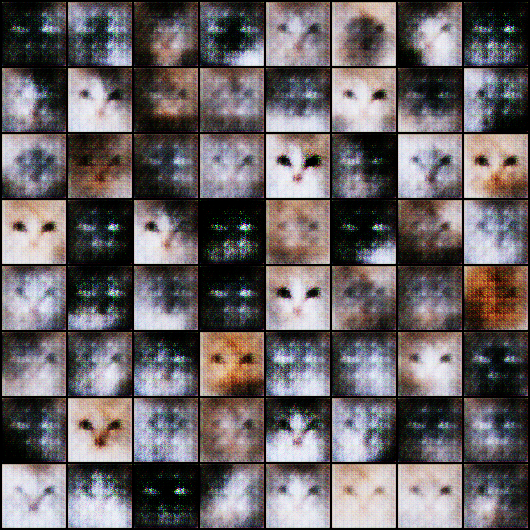

In [84]:
from IPython.display import Image
Image('./examples/IMAGE_EPOCH_0.png')

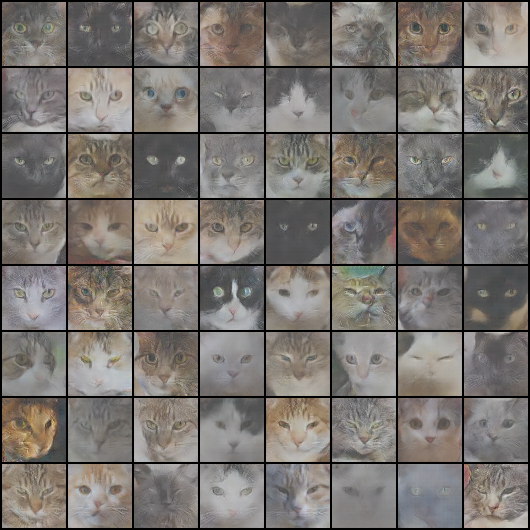

In [90]:
Image('./examples/IMAGE_EPOCH_99.png')

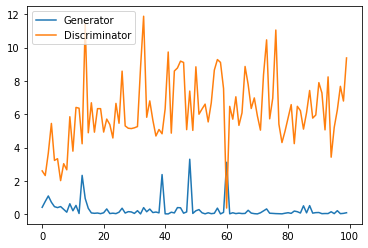

In [96]:
plt.plot(list(range(100)), lossD, label='Generator')
plt.plot(list(range(100)), lossG, label='Discriminator')
plt.legend()
plt.show()

In [88]:
# !rm -rf ./examples